# Practical Aspects of Image Classification

- **Topics will be covered in this chapter:**
    - Generating class activation maps (CAMs).
    - Understanding the impact of batch normalization and data augmentation
    - Practical aspects to take care of during model implementation

---
# Generating CAMs

###### This process helps to visualize and understand which parts of an image are particularly important for a neural network when identifying a specific class. The method uses gradients to highlight the relevant features in the intermediate activation maps.


- **Scenario**: Stakeholder wants to understand the reasoning behind a model's predictions.

- **Solution**: Class Activation Maps (CAMs) provide insight into model predictions.

- CAMs help interpret model decisions and provide transparency in prediction rationale.

Summary of CAM Generation:

- **Feature Maps:**
  - Intermediate activations post-convolution.
  - Typically in the shape of n-channels x height x width.

- **Identifying Hotspots:**
  - Mean of all activations reveals hotspots for all classes.

- **Class-specific Hotspots:**
  - To pinpoint locations crucial for a specific class (e.g., cat).
  - Identify feature maps among n-channels responsible for that class.

- **Gradient Computation:**
  - Compute gradients for the convolution layer corresponding to the cat class.
  - High gradients only in channels responsible for predicting cats.

- **Weightage Assignment:**
  - Utilize gradient information to assign weightage to each of n-channels.
  - Obtain an activation map exclusively highlighting areas relevant to the cat class.

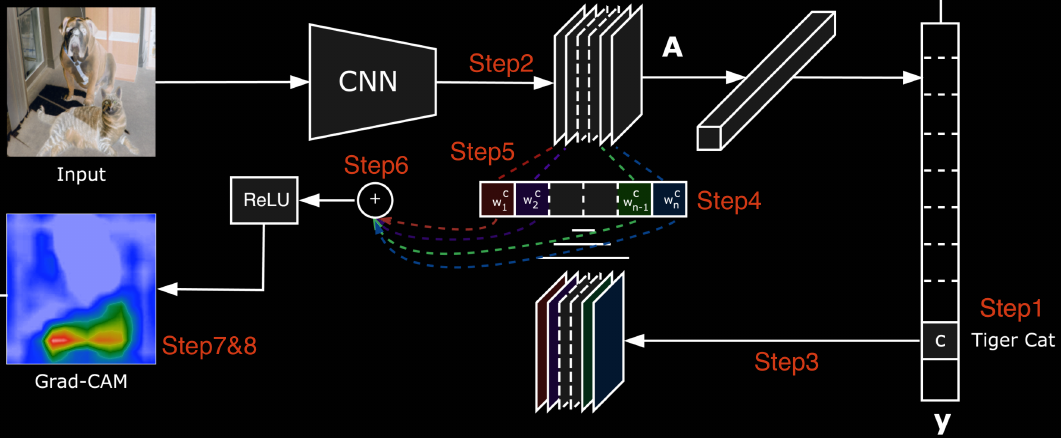

1. **Class and Layer Selection:**
   - Choose the target class and the convolutional layer for CAM computation.

2. **Activation Calculation:**
   - Calculate activations from the chosen convolutional layer.
   - Example: Feature shape is 512 x 7 x 7.

3. **Gradient Retrieval:**
   - Fetch gradient values from this layer concerning the class of interest.
   - Output shape: 256 x 512 x 3 x 3.

4. **Gradient Mean Calculation:**
   - Compute the mean of gradients within each output channel.
   - Output shape: 512.

5. **Weighted Activation Map:**
   - Multiply the 512 gradient means by the 512 activation channels.
   - Output shape: 512 x 7 x 7.

6. **Mean Across Channels:**
   - Calculate the mean across the 512 channels for a 7 x 7 output.

7. **Resize Activation Map:**
   - Upscale the weighted activation map to match the input image size.

8. **Overlay onto Input Image:**
   - Overlay the resized activation map onto the original input image.

The key to the entire process lies in step 5. We consider two aspects of the step:
- If a certain pixel is important, then the CNN will have a large activation at those pixels.
- If a certain convolutional channel is important with respect to the required class, the gradients at that channel will be very large

---
## CAMs implemented in code

In [35]:
# 1. Download the dataset and import the relevant packages
# Standard library imports
from pathlib import Path
from random import randint

# Third party imports
import cv2
from glob import glob
import numpy as np
import torch
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [2]:
# Constants
IMAGE_SIZE = 128
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]

# Specify the indices corresponding to the output classes
id2int = {'Parasitized': 0, 'Uninfected': 1}


# Define transformations for training images
train_transforms = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(IMAGE_SIZE),
    v2.CenterCrop(IMAGE_SIZE),
    v2.ColorJitter(brightness=(0.95,1.05),
                contrast=(0.95,1.05),
                saturation=(0.95,1.05),
                hue=0.05),
    v2.RandomAffine(5, translate=(0.01,0.1)),
    v2.Compose([v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize(mean=MEAN, std=STD),
])

# Specify the transformations for validation images
validation_transforms = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(IMAGE_SIZE),
    v2.CenterCrop(IMAGE_SIZE),
    v2.Compose([v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize(mean=MEAN, std=STD),
])

In [3]:
class MalariaImages(Dataset):
    def __init__(self, files, transform=None):
        self.files = list(map(str, files))
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = os.path.split(os.path.dirname(fpath))[-1]
        img = cv2.cvtColor(cv2.imread(fpath, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        if img is None:
            raise ValueError(f"Failed to load image: {fpath}")
        return img, clss
            
    def choose(self):
        return self[torch.randint(len(self), size=(1,)).item()]
        
    def collate_fn(self, batch):
        _imgs, classes = zip(*batch)
        if self.transform:
            imgs = torch.stack([self.transform(img) for img in _imgs])
        else:
            imgs = torch.stack([img for img in _imgs])
            
        classes = torch.tensor([id2int[clss] for clss in classes])
        
        # Move to device
        imgs = imgs.to(device)
        classes = classes.to(device)
        
        return imgs, classes, _imgs

In [4]:
# 5. Fetch the training and validation datasets and dataloaders
# Constants
SEED = 10
BATCH_SIZE = 32

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get all image files
all_files = glob('/home/elbahnasy/CodingWorkspace/Modern-Compyter-Vision/Chapter06/cell_images/*/*.png')
print(f"Found {len(all_files)} image files.")

# Check if the list is empty
if not all_files:
	raise ValueError("No image files found in the specified directory. Please check the path.")

# Set seed and shuffle files
np.random.seed(SEED)
np.random.shuffle(all_files)

# Split files into training and validation sets
train_files, validation_files = train_test_split(all_files, test_size=0.25, random_state=1)

# Create datasets
train_dataset = MalariaImages(train_files, transform=train_transforms)
validation_dataset = MalariaImages(validation_files, transform=validation_transforms)

# Create data loaders
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)
validation_dataloader = DataLoader(validation_dataset, BATCH_SIZE, shuffle=False, collate_fn=validation_dataset.collate_fn)

Found 27558 image files.


In [5]:
# 6. Define the model – MalariaClassifier
def create_convolutional_block(input_channels, output_channels):
    """
    Creates a convolutional block with dropout, convolution, ReLU activation,
    batch normalization and max pooling.
    """
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(output_channels),
        nn.MaxPool2d(2),
    )

class MalariaClassifier(nn.Module):
    """
    A classifier for detecting Malaria in images.
    """
    def __init__(self):
        super().__init__()
        layers = []
        channels = [3, 64, 64, 128, 256, 512, 64]
        for i in range(len(channels)-1):
            layers.append(create_convolutional_block(channels[i], channels[i+1]))
        layers.extend([
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int)),
            nn.LogSoftmax(dim=1)
        ])
        self.model = nn.Sequential(*layers)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, predictions, targets):
        """
        Computes the loss and accuracy for the given predictions and targets.
        """
        loss = self.loss_function(predictions, targets)
        accuracy = (torch.max(predictions, 1)[1] == targets).float().mean()
        return loss, accuracy

# 7. Define the functions to train and validate on a batch of data
def train_model_batch(model, batch_data, optimizer, criterion):
    """
    Trains the model for one batch of data.
    
    Parameters:
    model: The model to be trained.
    batch_data: The batch of data to be used for training. It should be a tuple of (images, labels).
    optimizer: The optimizer to be used for training.
    loss_function: The loss function to be used for training.
    
    Returns:
    The loss and accuracy for the batch as a tuple.
    """
    images, labels, _ = batch_data
    predictions = model(images)
    optimizer.zero_grad()
    loss, accuracy = criterion(predictions, labels)
    loss.backward()
    optimizer.step()
    return loss.item() , accuracy.item()

@torch.no_grad()
def validate_model_batch(model, batch_data, criterion):
    """
    Validates the model for one batch of data.
    
    Parameters:
    model: The model to be validated.
    batch_data: The batch of data to be used for validation. It should be a tuple of (images, labels).
    loss_function: The loss function to be used for validation.
    
    Returns:
    The loss and accuracy for the batch as a tuple.
    """
    images, labels, _ = batch_data
    predictions = model(images)
    loss, accuracy = criterion(predictions, labels)
    return loss.item(), accuracy.item()


In [6]:
def train_and_validate(model, num_epochs, train_dataloader, validation_dataloader, optimizer, criterion):
    """
    Trains and validates the model, printing average loss and accuracy for each epoch.

    Parameters:
    model: The model to be trained and validated.
    num_epochs: The number of epochs to train for.
    train_dataloader: The DataLoader for the training data.
    validation_dataloader: The DataLoader for the validation data.
    optimizer: The optimizer to be used for training.
    criterion: The loss function to be used for training and validation.

    Returns:
    None
    """
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_index, batch_data in enumerate(train_dataloader):
            loss, accuracy = train_model_batch(model, batch_data, optimizer, criterion)
            # Accumulate loss
            train_loss += loss.item() if torch.is_tensor(loss) else loss
            # Accumulate accuracy (assuming accuracy is fraction of correct predictions)
            batch_size = batch_data[0].size(0)  
            train_correct += accuracy * batch_size
            train_total += batch_size

        # Compute average training loss and accuracy
        avg_train_loss = train_loss / len(train_dataloader)
        avg_train_accuracy = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_index, batch_data in enumerate(validation_dataloader):
                loss, accuracy = validate_model_batch(model, batch_data, criterion)
                # Accumulate loss
                val_loss += loss.item() if torch.is_tensor(loss) else loss
                # Accumulate accuracy
                batch_size = batch_data[0].size(0)
                val_correct += accuracy * batch_size
                val_total += batch_size

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(validation_dataloader)
        avg_val_accuracy = val_correct / val_total

        # Print results for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")

In [7]:
# Instantiate the MalariaClassifier model and move it to the GPU if available
model = MalariaClassifier().to(device)

# Set the model's compute_metrics method as the criterion for calculating loss
criterion = model.compute_metrics

# Initialize the Adam optimizer with a learning rate of 0.001 and apply it to the model's parameters
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Set the number of epochs for which the model will be trained
num_epochs = 2



# Start the training and validation process. The function will train the model on the training data and validate it on the validation data.
# The optimizer and criterion defined above will be used, and the logger will record the process
train_and_validate(model, num_epochs,
                    train_dataloader, 
                    validation_dataloader,
                    optimizer, criterion)

Epoch 1/2:
  Train Loss: 0.2383, Train Accuracy: 0.9097
  Val Loss: 0.1937, Val Accuracy: 0.9411
Epoch 2/2:
  Train Loss: 0.1733, Train Accuracy: 0.9451
  Val Loss: 0.1542, Val Accuracy: 0.9530


In [24]:
list(model.model[:5].children()) + list(model.model[5][:2].children())

[Sequential(
   (0): Dropout(p=0.2, inplace=False)
   (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (2): ReLU(inplace=True)
   (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 ),
 Sequential(
   (0): Dropout(p=0.2, inplace=False)
   (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (2): ReLU(inplace=True)
   (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 ),
 Sequential(
   (0): Dropout(p=0.2, inplace=False)
   (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (2): ReLU(inplace=True)
   (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 ),
 Sequential(
   (0

In [47]:
import matplotlib.pyplot as plt
# 9. Fetch the convolution layer in the fifth convBlock in the model

im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

val_ds = MalariaImages(validation_files, transform=validation_transforms)

# 10. Define the im2gradCAM function that takes an input image and fetches the heatmap corresponding to activations of the image
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    activations = im2fmap(x)
    # print(activations.shape)
    pred = logits.max(-1)[-1]
    # get the model's prediction
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.model[-7][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

# 11. Define the upsampleHeatmap function to up-sample the heatmap to a shape that corresponds to the shape of the image

def upsampleHeatmap(map, img):
    m, M = map.min(), map.max()
    map = ((map - m) / (M - m)) * 255
    map = np.squeeze(map.numpy())
    map = cv2.resize(map, (img.shape[1], img.shape[0]))
    map = cv2.applyColorMap(255 - np.uint8(map), cv2.COLORMAP_JET)
    map = np.uint8(map * 0.7 + img * 0.3)
    return map


def plot_images_with_heatmaps(images, heatmaps, preds, ncols=4, img_size=128):
    n_images = len(images)
    nrows = (n_images + ncols - 1) // ncols  

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols*2, figsize=(ncols*4, nrows*4))
    axes = axes.flatten()

    for idx in range(n_images):
        orig = cv2.resize(images[idx], (img_size, img_size))
        heat = cv2.resize(heatmaps[idx], (img_size, img_size))

        # Plot original image
        ax = axes[2*idx]
        ax.imshow(orig)
        ax.set_title(f"Original\n{preds[idx]}", fontsize=10)
        ax.axis('off')

        # Plot heatmap
        ax = axes[2*idx + 1]
        ax.imshow(heat)
        ax.set_title(f"GradCAM\n{preds[idx]}", fontsize=10)
        ax.axis('off')

    # Hide any unused subplots
    for i in range(2*n_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

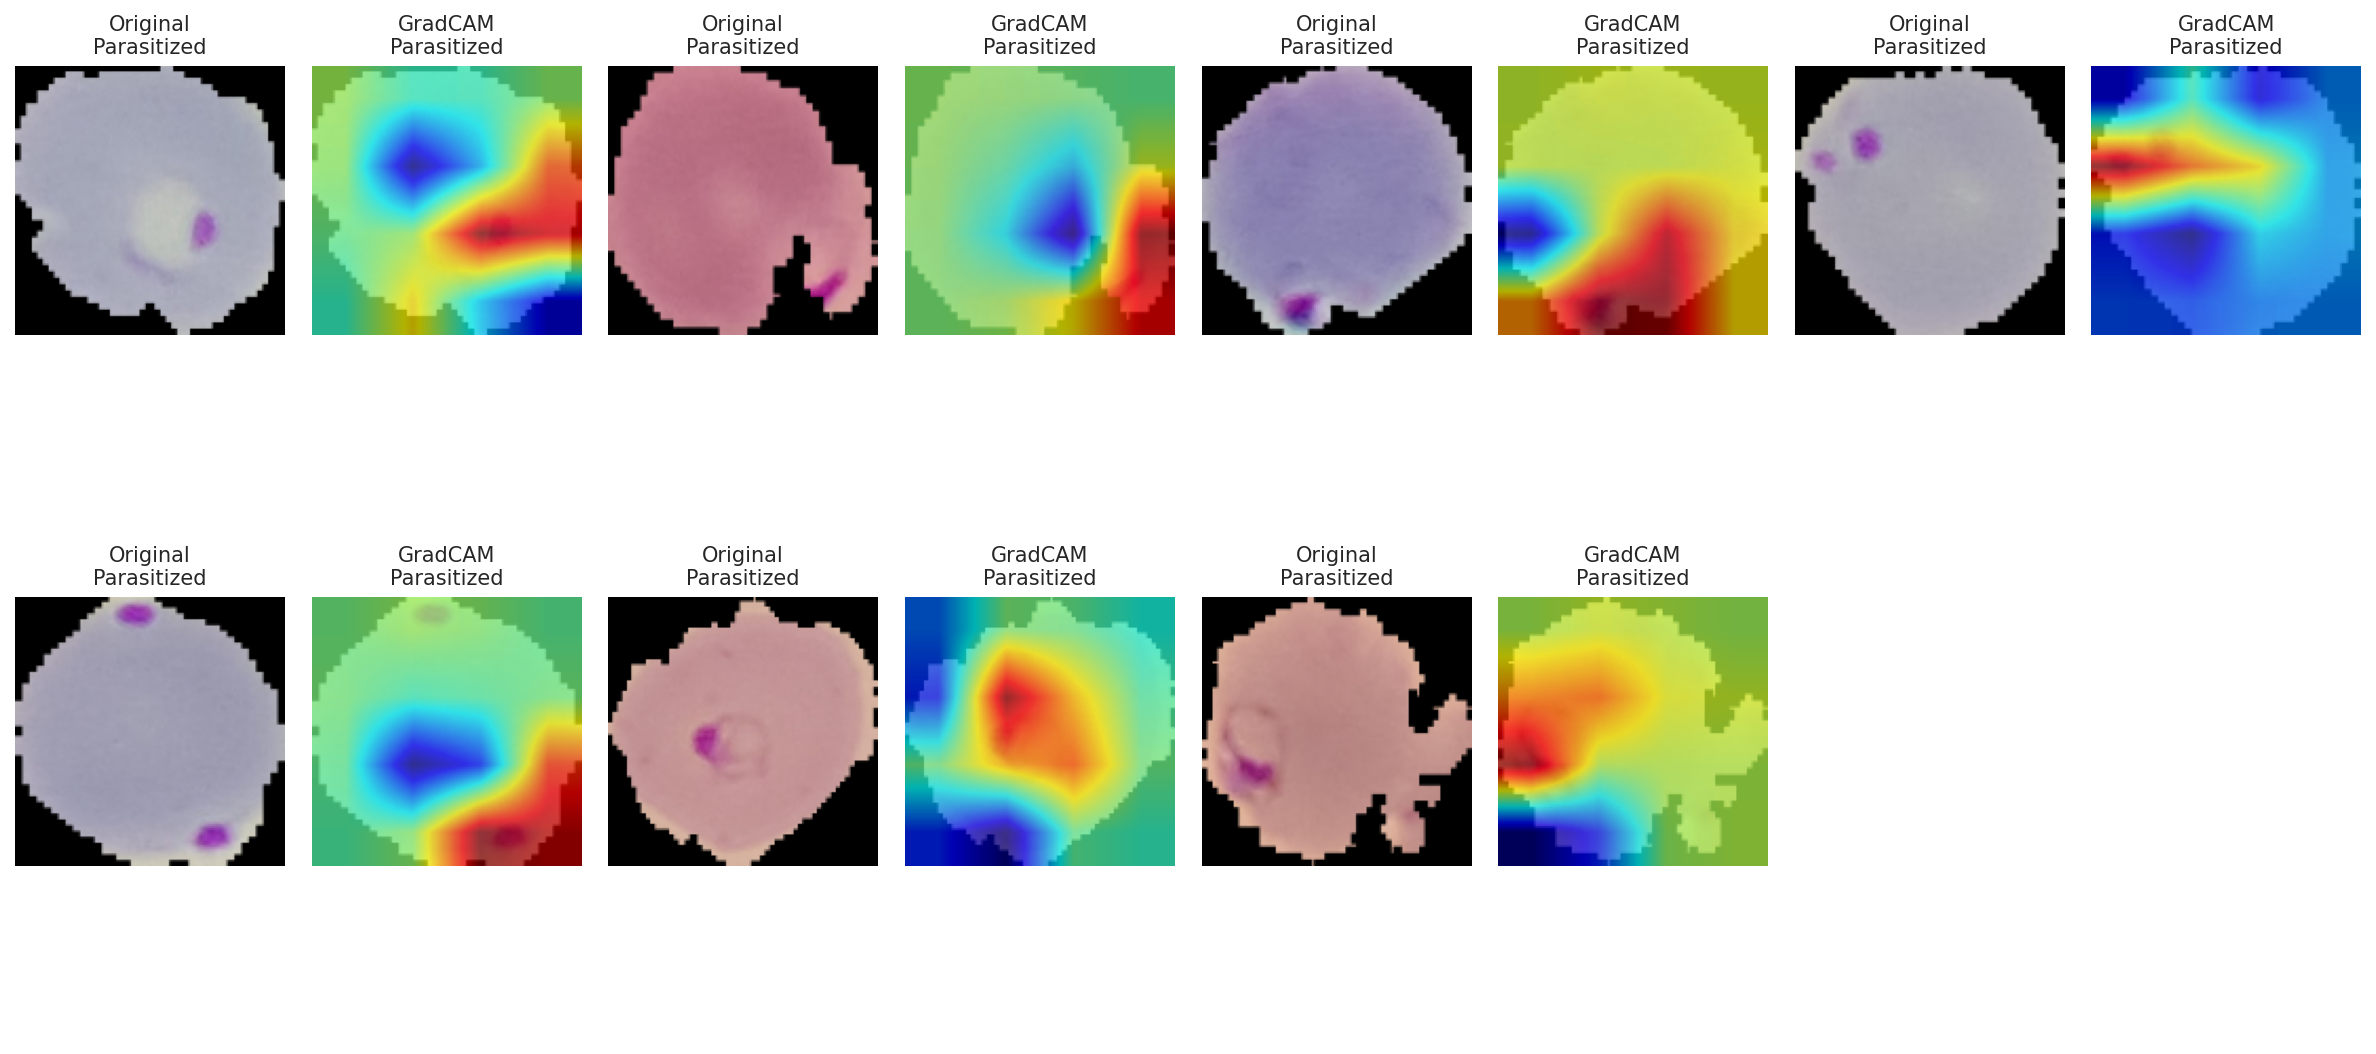

In [48]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x, y, z = next(iter(_val_dl))

orig_images = []
heatmaps = []
predictions = []

for i in range(N):
    image = z[i]
    img_resized = cv2.resize(image, (SZ, SZ))
    heatmap, pred = im2gradCAM(x[i:i+1])

    if pred == 'Uninfected':
        continue

    heatmap_colored = upsampleHeatmap(heatmap, img_resized)

    orig_images.append(img_resized)
    heatmaps.append(heatmap_colored)
    predictions.append(pred)
plot_images_with_heatmaps(orig_images, heatmaps, predictions, ncols=4, img_size=SZ)


---
# Understanding the impact of data augmentation and batch normalization

- To understand the impact of data augmentation and batch normalization, we will go through a dataset of recognizing traffic signs. We will evaluate three scenarios:
    - No batch normalization/data augmentation
    - Only batch normalization, but no data augmentation
    - Both batch normalization and data augmentation

# Coding up road sign detection

- Let's code up for road sign detection without data augmentation and batch normalization

#### 01. Download the dataset


In [20]:
import os
import requests
from glob import glob
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import  models
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt

In [21]:
# Check if the 'GTSRB' directory exists
if not os.path.exists('GTSRB'):
    # Define URLs for the files to download
    train_zip_url = 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip'
    test_zip_url = 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip'
    signnames_url = 'https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv'

    # Download the training images zip file
    train_zip = requests.get(train_zip_url)
    with open('GTSRB_Final_Training_Images.zip', 'wb') as f:
        f.write(train_zip.content)

    # Download the test images zip file
    test_zip = requests.get(test_zip_url)
    with open('GTSRB_Final_Test_Images.zip', 'wb') as f:
        f.write(test_zip.content)

    # Download the signnames CSV file
    signnames = requests.get(signnames_url)
    with open('signnames.csv', 'wb') as f:
        f.write(signnames.content)

    # Unzip the training images
    with zipfile.ZipFile('GTSRB_Final_Training_Images.zip', 'r') as zip_ref:
        zip_ref.extractall()

    # Unzip the test images
    with zipfile.ZipFile('GTSRB_Final_Test_Images.zip', 'r') as zip_ref:
        zip_ref.extractall()

    # Remove the zip files after extraction
    os.remove('GTSRB_Final_Training_Images.zip')
    os.remove('GTSRB_Final_Test_Images.zip')

In [22]:
df = pd.read_csv('signnames.csv', index_col='ClassId')
classIds = {f'{class_id:05d}': name for class_id, name in df['SignName'].items()}
id2int = {name: idx for idx, name in enumerate(classIds.values())}

In [23]:
# Constants
IMAGE_SIZE = 32 
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Define transformations for training images
train_transforms = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(IMAGE_SIZE),
    v2.CenterCrop(IMAGE_SIZE),
    v2.ColorJitter(brightness=(0.8,1.2),
                contrast=(0.8,1.2),
                saturation=(0.8,1.2),
                hue=0.25),
    v2.RandomAffine(5, translate=(0.01,0.1)),
    v2.Compose([v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize(mean=MEAN, std=STD),
])

# Specify the transformations for validation images
validation_transforms = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(IMAGE_SIZE),
    v2.CenterCrop(IMAGE_SIZE),
    v2.Compose([v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize(mean=MEAN, std=STD),
])

In [24]:
class GTSRB(Dataset):
    def __init__(self, files, transform=None):
        super().__init__()
        self.files = list(map(str, files))
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, index):
        try:
            fpath = self.files[index]
            clss = Path(fpath).parent.name
            img = cv2.cvtColor(cv2.imread(fpath, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
            if img is None:
                raise ValueError(f"Failed to load image: {fpath}")
            return img, classIds[clss]
        except:
            Warning(f'Missing {fpath}. Loading a different image')
            return self[torch.randint(len(self))]
    def choose(self):
        return self[torch.randint(len(self), size=(1,)).item()]
    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = torch.stack([self.transform(img) for img in imgs])
        else:
            imgs = torch.stack([img for img in imgs])
        classes = torch.tensor([id2int[clss] for clss in classes])
        # Move to device
        imgs = imgs.to(device)
        classes = classes.to(device)
        return imgs, classes

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Get all image files
all_files = glob('GTSRB/Final_Training/Images/*/*.ppm')
print(f"Found {len(all_files)} image files.")
np.random.seed(10)
np.random.shuffle(all_files)

Found 39209 image files.


In [26]:
train_files, validation_files = train_test_split(all_files, test_size=0.25, random_state=1)
# Create datasets
train_dataset = GTSRB(train_files, transform=train_transforms)
validation_dataset = GTSRB(validation_files, transform=validation_transforms)
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=train_dataset.collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False, collate_fn=validation_dataset.collate_fn)

In [27]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc

In [ ]:
def train_model_batch(model, batch_data, optimizer, criterion):
    """
    Trains the model for one batch of data.
    
    Parameters:
    model: The model to be trained.
    batch_data: The batch of data to be used for training. It should be a tuple of (images, labels).
    optimizer: The optimizer to be used for training.
    loss_function: The loss function to be used for training.
    
    Returns:
    The loss and accuracy for the batch as a tuple.
    """
    images, labels = batch_data
    predictions = model(images)
    optimizer.zero_grad()
    loss, accuracy = criterion(predictions, labels)
    loss.backward()
    optimizer.step()
    return loss.item() , accuracy.item()

@torch.no_grad()
def validate_model_batch(model, batch_data, criterion):
    """
    Validates the model for one batch of data.
    
    Parameters:
    model: The model to be validated.
    batch_data: The batch of data to be used for validation. It should be a tuple of (images, labels).
    loss_function: The loss function to be used for validation.
    
    Returns:
    The loss and accuracy for the batch as a tuple.
    """
    images, labels = batch_data
    predictions = model(images)
    loss, accuracy = criterion(predictions, labels)
    return loss.item(), accuracy.item()

def train_and_validate(model, num_epochs, train_dataloader, validation_dataloader, optimizer, criterion):
    """
    Trains and validates the model, printing average loss and accuracy for each epoch.

    Parameters:
    model: The model to be trained and validated.
    num_epochs: The number of epochs to train for.
    train_dataloader: The DataLoader for the training data.
    validation_dataloader: The DataLoader for the validation data.
    optimizer: The optimizer to be used for training.
    criterion: The loss function to be used for training and validation.

    Returns:
    train_losses: List of training losses for each epoch.
    train_accuracies: List of training accuracies for each epoch.
    val_losses: List of validation losses for each epoch.
    val_accuracies: List of validation accuracies for each epoch.
    """
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_index, batch_data in enumerate(train_dataloader):
            loss, accuracy = train_model_batch(model, batch_data, optimizer, criterion)
            # Accumulate loss
            train_loss += loss.item() if torch.is_tensor(loss) else loss
            # Accumulate accuracy (assuming accuracy is fraction of correct predictions)
            batch_size = batch_data[0].size(0)  
            train_correct += accuracy * batch_size
            train_total += batch_size

        # Compute average training loss and accuracy
        avg_train_loss = train_loss / len(train_dataloader)
        avg_train_accuracy = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_index, batch_data in enumerate(validation_dataloader):
                loss, accuracy = validate_model_batch(model, batch_data, criterion)
                # Accumulate loss
                val_loss += loss.item() if torch.is_tensor(loss) else loss
                # Accumulate accuracy
                batch_size = batch_data[0].size(0)
                val_correct += accuracy * batch_size
                val_total += batch_size

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(validation_dataloader)
        avg_val_accuracy = val_correct / val_total

        # Print results for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
    return train_losses, train_accuracies, val_losses, val_accuracies

def plot_training_validation_accuracies(train_accuracies, val_accuracies, num_epochs=40):
    """
    Plot the variation of training and validation accuracies over increasing epochs.

    Parameters:
    - train_accuracies (list): List of training accuracies for each epoch.
    - val_accuracies (list): List of validation accuracies for each epoch.
    - num_epochs (int): Number of epochs. Default is 5.
    """

    epochs = np.arange(1, num_epochs + 1)

    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')

    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [15]:
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 40
train_losses, train_accuracies, val_losses, val_accuracies=train_and_validate(model, num_epochs,
                                                                                train_dataloader, 
                                                                                validation_dataloader,
                                                                                optimizer, criterion)

Epoch 1/40:
  Train Loss: 2.3210, Train Accuracy: 0.3198
  Val Loss: 1.0927, Val Accuracy: 0.6831
Epoch 2/40:
  Train Loss: 0.9991, Train Accuracy: 0.6763
  Val Loss: 0.7094, Val Accuracy: 0.8122
Epoch 3/40:
  Train Loss: 0.7047, Train Accuracy: 0.7684
  Val Loss: 0.6498, Val Accuracy: 0.8366
Epoch 4/40:
  Train Loss: 0.5759, Train Accuracy: 0.8130
  Val Loss: 0.5718, Val Accuracy: 0.8570
Epoch 5/40:
  Train Loss: 0.4952, Train Accuracy: 0.8376
  Val Loss: 0.5005, Val Accuracy: 0.8748
Epoch 6/40:
  Train Loss: 0.4403, Train Accuracy: 0.8556
  Val Loss: 0.5639, Val Accuracy: 0.8487
Epoch 7/40:
  Train Loss: 0.4090, Train Accuracy: 0.8664
  Val Loss: 0.5712, Val Accuracy: 0.8378
Epoch 8/40:
  Train Loss: 0.3936, Train Accuracy: 0.8711
  Val Loss: 0.4882, Val Accuracy: 0.8618
Epoch 9/40:
  Train Loss: 0.3609, Train Accuracy: 0.8839
  Val Loss: 0.6615, Val Accuracy: 0.8295
Epoch 10/40:
  Train Loss: 0.3478, Train Accuracy: 0.8869
  Val Loss: 0.7631, Val Accuracy: 0.8113
Epoch 11/40:
  Trai

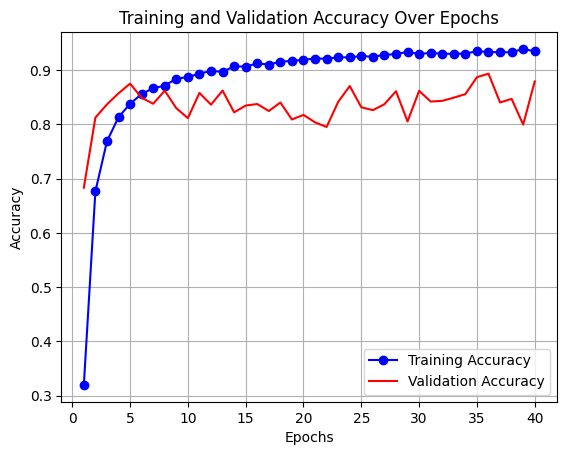

In [19]:
plot_training_validation_accuracies(train_accuracies, val_accuracies, 40)

### with data augmentation and batch normalization


In [30]:
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 40
train_losses1, train_accuracies1, val_losses1, val_accuracies1=train_and_validate(model, num_epochs,
                                                                                train_dataloader, 
                                                                                validation_dataloader,
                                                                                optimizer, criterion)

Epoch 1/40:
  Train Loss: 1.9185, Train Accuracy: 0.4422
  Val Loss: 1.4271, Val Accuracy: 0.6144
Epoch 2/40:
  Train Loss: 0.7032, Train Accuracy: 0.7763
  Val Loss: 0.7153, Val Accuracy: 0.7975
Epoch 3/40:
  Train Loss: 0.4905, Train Accuracy: 0.8405
  Val Loss: 0.5505, Val Accuracy: 0.8345
Epoch 4/40:
  Train Loss: 0.3961, Train Accuracy: 0.8709
  Val Loss: 0.5402, Val Accuracy: 0.8586
Epoch 5/40:
  Train Loss: 0.3399, Train Accuracy: 0.8869
  Val Loss: 0.3856, Val Accuracy: 0.8929
Epoch 6/40:
  Train Loss: 0.3075, Train Accuracy: 0.8998
  Val Loss: 0.5429, Val Accuracy: 0.8500
Epoch 7/40:
  Train Loss: 0.2698, Train Accuracy: 0.9114
  Val Loss: 0.3055, Val Accuracy: 0.9050
Epoch 8/40:
  Train Loss: 0.2514, Train Accuracy: 0.9178
  Val Loss: 0.3769, Val Accuracy: 0.8897
Epoch 9/40:
  Train Loss: 0.2263, Train Accuracy: 0.9259
  Val Loss: 0.3083, Val Accuracy: 0.9110
Epoch 10/40:
  Train Loss: 0.2120, Train Accuracy: 0.9304
  Val Loss: 0.4238, Val Accuracy: 0.8898
Epoch 11/40:
  Trai

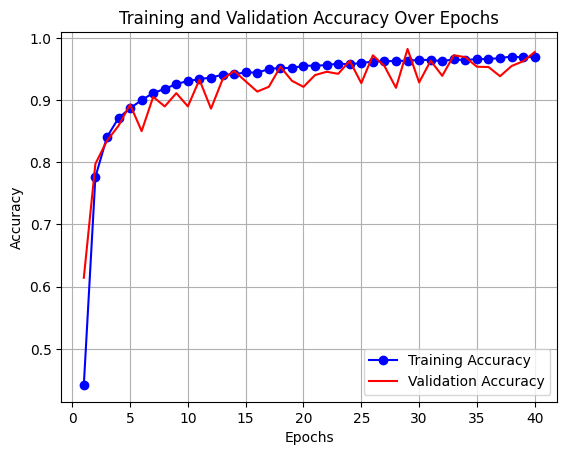

In [31]:
plot_training_validation_accuracies(train_accuracies1, val_accuracies1, 40)